In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
   # for filename in filenames:
      #  print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras import layers, Input
from keras.layers import InputLayer, MaxPooling2D, Flatten, Dense, Conv2D, Dropout
from keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from tensorflow.keras.optimizers import Adam, SGD

# لخلط البيانات 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from PIL.Image import open

from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
import random
%matplotlib inline

In [3]:
# Constants
#../input/brain-tumor
#../input/brain-tumor/Brain Tumor/Brain Tumor
IMAGE_DATASET = "../input/brain-tumor/Brain Tumor/Brain Tumor"
IMAGE_DATASET_RAW = r"..\input\brain-tumor\Brain Tumor\Brain Tumor"
WORKING_FOLDER = "/kaggle/working"
# الابعاد مع عدد المحاولات 
IMG_HEIGHT = 224
IMG_WIDTH = 224
EPOCHS = 50

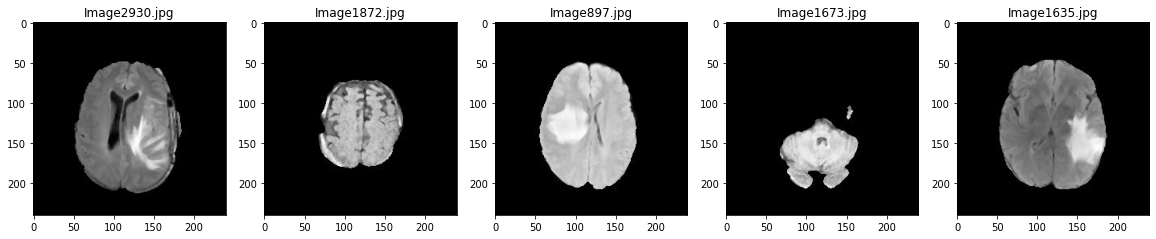

In [4]:
cortex_df = pd.read_csv("../input/brain-tumor/Brain Tumor.csv")
plt.figure(figsize=(20,20))
test_folder="../input/brain-tumor/Brain Tumor/Brain Tumor" 
for i in range(5):
    file = random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)
    

# **Loading Dataset**

In [5]:
dataset_df = pd.DataFrame()
dataset_df["Image"] = cortex_df["Image"]
dataset_df["Class"] = cortex_df["Class"]
path_list = []
for img_path in os.listdir(IMAGE_DATASET):
    path_list.append( os.path.join(IMAGE_DATASET,img_path))
path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in path_list}
dataset_df["paths"] = cortex_df["Image"].map(path_dict.get)
dataset_df["pixels"] = dataset_df["paths"].map(lambda x:np.asarray(open(x).resize((IMG_HEIGHT,IMG_WIDTH))))
dataset_df.head(10)

,Image,Class,paths,pixels
0,Image1,0,../input/brain-tumor/Brain Tumor/Brain Tumor/I...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,Image2,0,../input/brain-tumor/Brain Tumor/Brain Tumor/I...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,Image3,1,../input/brain-tumor/Brain Tumor/Brain Tumor/I...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,Image4,1,../input/brain-tumor/Brain Tumor/Brain Tumor/I...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,Image5,0,../input/brain-tumor/Brain Tumor/Brain Tumor/I...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
5,Image6,0,../input/brain-tumor/Brain Tumor/Brain Tumor/I...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
6,Image7,0,../input/brain-tumor/Brain Tumor/Brain Tumor/I...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
7,Image8,0,../input/brain-tumor/Brain Tumor/Brain Tumor/I...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
8,Image9,0,../input/brain-tumor/Brain Tumor/Brain Tumor/I...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
9,Image10,1,../input/brain-tumor/Brain Tumor/Brain Tumor/I...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [6]:
image_list = []
for i in range(len(dataset_df)):
    brain_image = dataset_df["pixels"][i].astype(np.float32)
    brain_image /= 255
    image_list.append(brain_image)
X = np.array(image_list)
print(X.shape)

(3762, 224, 224, 3)


In [7]:
y = np.array(dataset_df.Class)
y.shape

(3762,)

# **Splitting Dataset**

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('The shape of the X_train :'+' '+str(X_train.shape))
print('The size of the X_train :'+' '+str(y_train.shape))
print('The shape of the X_test :'+' '+str(X_test.shape))
print('The size of the X_test:'+' '+str(y_test.shape))

The shape of the X_train : (3009, 224, 224, 3)
The size of the X_train : (3009,)
The shape of the X_test : (753, 224, 224, 3)
The size of the X_test: (753,)


In [9]:
from tensorflow.keras.layers import AveragePooling2D
loss_fn = BinaryCrossentropy()

# **Implementing Model**

In [10]:
model=Sequential()
model.add(Conv2D(16,(3,3),padding="valid",strides=2, activation="relu",input_shape=(224,224,3)))
model.add(Conv2D(16,(5,5),padding="valid",strides=2, activation="relu"))
model.add(AveragePooling2D(pool_size=(3,3),strides=2,padding="same"))
model.add(Conv2D(32,(3,3),padding="same",strides=1,activation='relu'))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Conv2D(32,(3,3),padding="valid",strides=1,activation='relu'))
model.add(Conv2D(64, kernel_size=3, strides=(2, 2), padding="same", activation="relu"))
model.add(Conv2D(64, kernel_size=3, strides=(2, 2), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last", padding='same'))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(120,activation="relu"))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss=loss_fn, optimizer='adam', metrics=['accuracy'] )

2022-05-26 12:48:25.419225: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 111, 111, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 54, 54, 16)        6416      
_________________________________________________________________
average_pooling2d (AveragePo (None, 27, 27, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 32)        4640      
_________________________________________________________________
average_pooling2d_1 (Average (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 64)          1

# **Training**

In [12]:
print(X_train.shape)
print(y_train.shape)
from time import time
tic= time()
epoch = 15
hist=model.fit(X_train, y_train, validation_split= 0.2, epochs=epoch, batch_size=100, verbose=1)
toc=time()
print("Training Time : {}".format(toc-tic))

(3009, 224, 224, 3)
(3009,)


2022-05-26 12:48:29.280844: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15
25/25 [==============================] - 8s 275ms/step - loss: 0.5721 - accuracy: 0.7013 - val_loss: 0.5074 - val_accuracy: 0.7525
Epoch 2/15
25/25 [==============================] - 6s 223ms/step - loss: 0.4846 - accuracy: 0.7777 - val_loss: 0.4694 - val_accuracy: 0.7841
Epoch 3/15
25/25 [==============================] - 6s 229ms/step - loss: 0.4485 - accuracy: 0.7964 - val_loss: 0.4802 - val_accuracy: 0.7907
Epoch 4/15
25/25 [==============================] - 6s 221ms/step - loss: 0.4306 - accuracy: 0.8139 - val_loss: 0.4112 - val_accuracy: 0.8189
Epoch 5/15
25/25 [==============================] - 6s 225ms/step - loss: 0.3794 - accuracy: 0.8388 - val_loss: 0.3940 - val_accuracy: 0.8156
Epoch 6/15
25/25 [==============================] - 6s 244ms/step - loss: 0.3550 - accuracy: 0.8533 - val_loss: 0.4703 - val_accuracy: 0.7924
Epoch 7/15
25/25 [==============================] - 6s 222ms/step - loss: 0.3777 - accuracy: 0.8255 - val_loss: 0.3670 - val_accuracy: 0.8389
Epoch 

In [13]:
def decode_sentiment(score):
    return 1 if score>0.5 else 0

# **Model Evaluation**

In [14]:
from sklearn import metrics
scores = model.predict(X_test)
y_pred = [decode_sentiment(score) for score in scores]
metrics.accuracy_score(y_test, y_pred)

0.9123505976095617

In [15]:
print("classification report:")
print(metrics.classification_report(y_test, y_pred))#, target_names=target_names))

classification report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       408
           1       0.88      0.94      0.91       345

    accuracy                           0.91       753
   macro avg       0.91      0.91      0.91       753
weighted avg       0.91      0.91      0.91       753



Text(0.5, 1.0, 'Loss evolution')

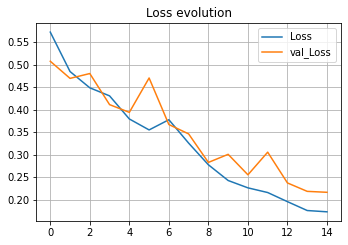

In [16]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(hist.history['loss'], label='Loss')
plt.plot(hist.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

Text(0.5, 1.0, 'Accuracy evolution')

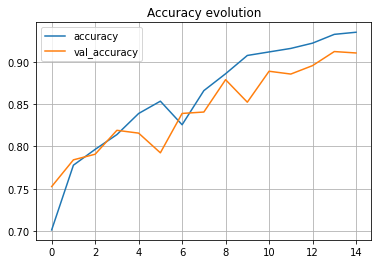

In [17]:
plt.subplot(1, 1, 1)
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy evolution')

confusion matrix: 


<AxesSubplot:>

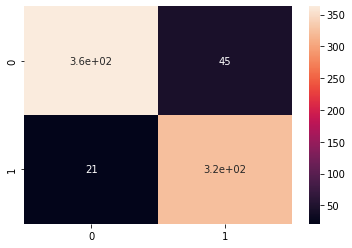

In [18]:
import seaborn as sns
print("confusion matrix: ")
cf_matrix=metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)

<AxesSubplot:>

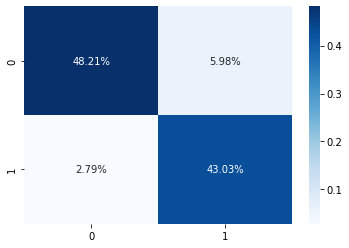

In [19]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')